In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [38]:
import seaborn as sns

In [40]:
import gmaps
import gmaps.geojson_geometries

In [2]:
beer_tax_data = pd.read_csv("resources/brewers_association_data_with_tax_data_2.csv", index_col = 0)
beer_tax_data.head()

,STATE,ZIP Code,NUMBER OF RETURNS,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT,Brewery,Address,City
0,AL,35004.0,5210.0,5210.0,290260.0,4550.0,234833.0,NaN,NaN,NaN
1,AL,35005.0,3100.0,3100.0,121690.0,2660.0,98565.0,NaN,NaN,NaN
2,AL,35006.0,1200.0,1200.0,57418.0,1040.0,43707.0,NaN,NaN,NaN
3,AL,35007.0,11940.0,11940.0,697882.0,10180.0,545418.0,siluria brewing company,145 1st ave w,Alabaster
4,AL,35010.0,7910.0,7910.0,384319.0,6700.0,266658.0,NaN,NaN,NaN


In [6]:
# Maybe I need to create a dataframe that aggregates just the tax data by state, then re-merge that with a dataframe
# that groups breweries by state?

state_tax_df = beer_tax_data[["STATE", "ZIP Code", "NUMBER OF RETURNS WITH TOTAL INCOME", "TOTAL INCOME AMOUNT",
                             "NUMBER OF RETURNS WITH SALARIES AND WAGES", "SALARIES AND WAGES AMOUNT"]]
state_brewer_data = beer_tax_data[["STATE", "ZIP Code", "Brewery", "Address", "City"]]

In [7]:
state_tax_df.head()

,STATE,ZIP Code,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT
0,AL,35004.0,5210.0,290260.0,4550.0,234833.0
1,AL,35005.0,3100.0,121690.0,2660.0,98565.0
2,AL,35006.0,1200.0,57418.0,1040.0,43707.0
3,AL,35007.0,11940.0,697882.0,10180.0,545418.0
4,AL,35010.0,7910.0,384319.0,6700.0,266658.0


In [9]:
state_tax_df.count()

STATE                                        32745
ZIP Code                                     32735
NUMBER OF RETURNS WITH TOTAL INCOME          32681
TOTAL INCOME AMOUNT                          32681
NUMBER OF RETURNS WITH SALARIES AND WAGES    32681
SALARIES AND WAGES AMOUNT                    32681
dtype: int64

In [10]:
state_tax_no_na_df = state_tax_df.dropna(how = "any")
state_tax_no_na_df.count()

STATE                                        32681
ZIP Code                                     32681
NUMBER OF RETURNS WITH TOTAL INCOME          32681
TOTAL INCOME AMOUNT                          32681
NUMBER OF RETURNS WITH SALARIES AND WAGES    32681
SALARIES AND WAGES AMOUNT                    32681
dtype: int64

In [8]:
state_brewer_data.head()

,STATE,ZIP Code,Brewery,Address,City
0,AL,35004.0,NaN,NaN,NaN
1,AL,35005.0,NaN,NaN,NaN
2,AL,35006.0,NaN,NaN,NaN
3,AL,35007.0,siluria brewing company,145 1st ave w,Alabaster
4,AL,35010.0,NaN,NaN,NaN


In [11]:
state_brewer_data.count()

STATE       32745
ZIP Code    32735
Brewery      7287
Address      7286
City         7287
dtype: int64

In [12]:
state_brewer_no_na_df = state_brewer_data.dropna(subset=["STATE", "Brewery"], how = "any")
state_brewer_no_na_df.count()

STATE       7287
ZIP Code    7277
Brewery     7287
Address     7286
City        7287
dtype: int64

In [35]:
CA_breweries = state_brewer_no_na_df.loc[state_brewer_no_na_df["STATE"] == "CA"]
print(len(CA_breweries))

# CA is our outlier on brewery count

847


In [19]:
brewer_state_groups = state_brewer_no_na_df.groupby(by="STATE")
state_brews = brewer_state_groups.count()

brewers_by_state_df = pd.DataFrame(state_brews)
brewers_by_state_df.reset_index(inplace=True)
brewers_by_state_df.head()

,STATE,ZIP Code,Brewery,Address,City
0,AK,41,41,41,41
1,AL,42,42,41,42
2,AR,39,39,39,39
3,AZ,118,118,118,118
4,CA,845,847,847,847


In [25]:
tax_state_groups = state_tax_no_na_df.groupby(by="STATE")
state_tax_means = tax_state_groups.mean()
tax_by_state_df = pd.DataFrame(state_tax_means)
tax_by_state_df.reset_index(inplace=True)
tax_by_state_df.head()

,STATE,ZIP Code,NUMBER OF RETURNS WITH TOTAL INCOME,TOTAL INCOME AMOUNT,NUMBER OF RETURNS WITH SALARIES AND WAGES,SALARIES AND WAGES AMOUNT
0,AK,99671.184524,2588.988095,183958.494048,2198.571429,127301.089286
1,AL,35952.172414,3469.950739,200435.201970,2918.587849,140634.338259
2,AR,72314.294455,2655.411090,163030.388145,2250.516252,105676.304015
3,AZ,85616.058685,8370.093897,531552.845070,6929.859155,361805.767606
4,CA,93539.706845,11992.881944,978355.903274,9985.466270,667623.095238


In [29]:
state_summary_df = pd.merge(tax_by_state_df, brewers_by_state_df, on = "STATE")
state_summary_df.drop(["ZIP Code_x", "ZIP Code_y", "Address", "City"], axis = 1, inplace = True)
state_summary_df.rename(columns = {
    "NUMBER OF RETURNS WITH TOTAL INCOME": "Mean # Total Income Returns",
    "TOTAL INCOME AMOUNT": "Mean Total Income",
    "NUMBER OF RETURNS WITH SALARIES AND WAGES": "Mean # Returns with Salaries and Wages",
    "SALARIES AND WAGES AMOUNT": "Mean Salaries and Wages",
    "Brewery": "Brewery Count"
}, inplace=True)
state_summary_df.head()

,STATE,Mean # Total Income Returns,Mean Total Income,Mean # Returns with Salaries and Wages,Mean Salaries and Wages,Brewery Count
0,AK,2588.988095,183958.494048,2198.571429,127301.089286,41
1,AL,3469.950739,200435.201970,2918.587849,140634.338259,42
2,AR,2655.411090,163030.388145,2250.516252,105676.304015,39
3,AZ,8370.093897,531552.845070,6929.859155,361805.767606,118
4,CA,11992.881944,978355.903274,9985.466270,667623.095238,847


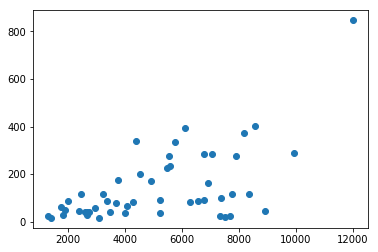

In [31]:
plt.scatter(state_summary_df["Mean # Total Income Returns"], state_summary_df["Brewery Count"])

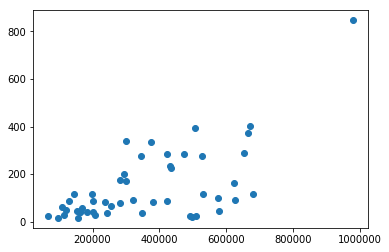

In [32]:
plt.scatter(state_summary_df["Mean Total Income"], state_summary_df["Brewery Count"])

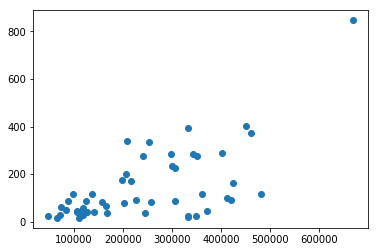

In [33]:
plt.scatter(state_summary_df["Mean Salaries and Wages"], state_summary_df["Brewery Count"])

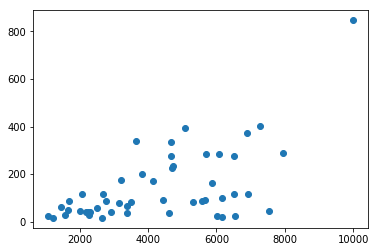

In [36]:
plt.scatter(state_summary_df["Mean # Returns with Salaries and Wages"], state_summary_df["Brewery Count"])

In [ ]:
# Definitely a correlation, but not much of one


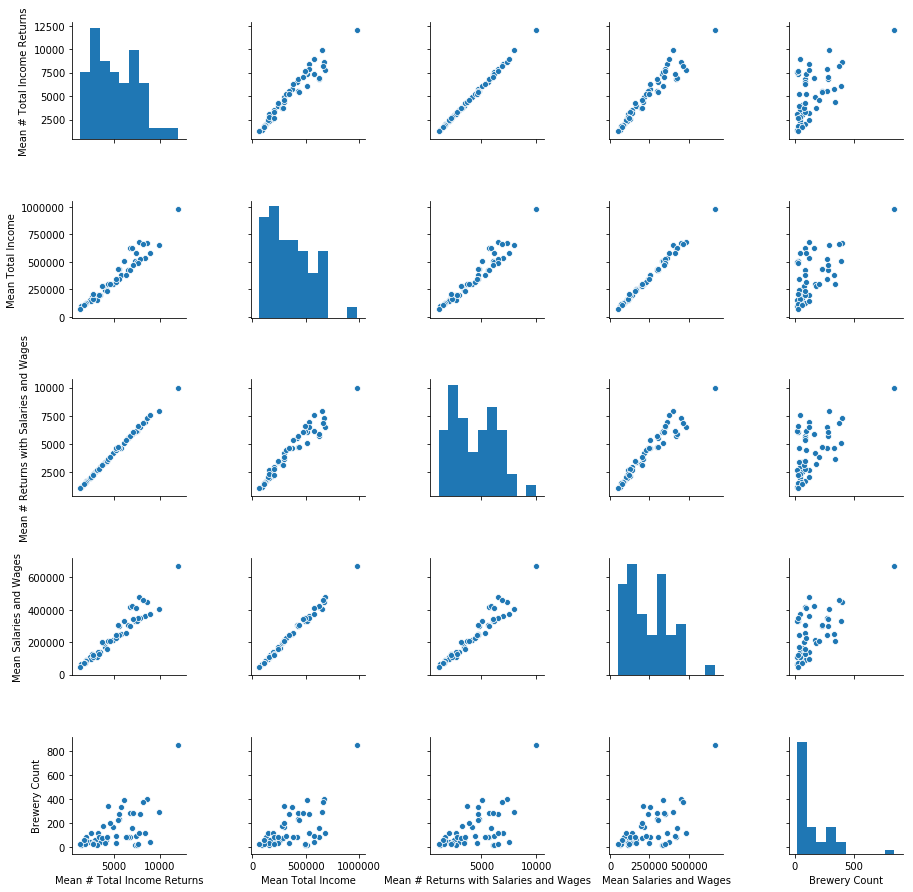

In [39]:
sns.pairplot(state_summary_df)
# Pretty
# The almost perfectly linear relationships between the different tax variables are a nice indicator that we're not working with
# wonky data

In [ ]:
# To Do: run regression analyses
# To Do: plot heat maps